# T4ps Form Extraction

In [6]:
import fitz
import numpy as np
import cv2 as cv

import os
import pytesseract
import cv2
import time
import pickle
import re
import os
import json
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from utils import *
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from detectron2.engine import DefaultPredictor


cfg_save_path = "t4ps_cfg.pickle"

with open(cfg_save_path, 'rb') as f:
    cfg = pickle.load(f)

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)


class PDF_T4ps_ImageExtractor:
    """
    page_number=1 (Page Number to convert into image)
    """
    def __init__(self, pdf_file_path, output_image_path,template_json,page_number=1):
        self.pdf_file_path = pdf_file_path
        self.output_image_path = output_image_path
        self.page_number = page_number
        self.template_json = template_json
        self.mapping_dict = {0: "Actual amount of dividends other than eligible dividends",
                             1: "Taxable amount of dividends other than eligible dividends",
                             2: "Dividend tax credit for dividends other than eligible dividends",
                             3: "Actual amount of eligible dividends",
                             4: "Taxable amount of eligible dividends",
                             5: "Dividend tax credit eligible dividends",
                             6: "Capital gain or losses",
                             7: "Other employement income",
                             8: "Total Amount forfeited due to withdrawal from plan",
                             9: "Foreign Non business income",
                             10: "Foreign Capital Gains or losses",
                             11: "Foreign Non business income tax",
                             12: "Specified Employee",
                             13: "Employees profit sharing plan contributions",
                             14: "Employer's account number",
                             15: "Employee's name",
                             16: "Employee's address",
                             17: "Employer's name",
                             18: "Name of employees profit sharing plan",
                             19: "Social insurance number",
                             20: "Year"}
        

    def convert_pdf_to_image(self):
        try:
            pdf_document = fitz.open(self.pdf_file_path)
            dpi = 300
            first_page = pdf_document.load_page(self.page_number - 1)
            pix = first_page.get_pixmap(matrix=fitz.Matrix(dpi / 72, dpi / 72))
            pix.save(self.output_image_path)
            
            # Load the image
            image = cv2.imread(self.output_image_path)
            
            # Specify the upper and lower line coordinates (y-coordinates)
            upper_line_y = 60  # Adjust this value as needed
            lower_line_y = 1600  # Adjust this value as needed
            

            # Crop the image using the specified lines
            cropped_image = image[upper_line_y:lower_line_y, :]
            cv2.imwrite(self.output_image_path, cropped_image)
            
            pdf_document.close()
            print(f'Conversion of the first page to {self.output_image_path} completed.')
            return True
        except Exception as e:
            print(f"Error: Pdf to Image Conversion failed!! {str(e)}")
            return False
    

    def final_json_creation(self,final_mapping):
        final_mapping_modified = {}
        for key, value in final_mapping.items():
            
            final_mapping_modified[key] = value
            return final_mapping_modified

    def crop_image(self,image_path, predictor):
        
        # reader = easyocr.Reader(['en'])
#         try:
#             reader = easyocr.Reader(['en'],  model_storage_directory='/pas-models/easy-ocr-temp', user_folder='/pas-models/easy-ocr-temp')
#         except:
#             try:
#                 reader = easyocr.Reader(['en'],  model_storage_directory='/pas-models/easy-ocr-temp')
#             except:
#                 reader = easyocr.Reader(['en'])
                
                
        reader = easyocr.Reader(['en'])
        im = cv2.imread(image_path)
        outputs = predictor(im)

        boxes_list = outputs["instances"].pred_boxes.tensor.cpu().numpy()
        scores_list = outputs["instances"].scores.detach().cpu().numpy()
        pred_classes_list = outputs["instances"].pred_classes.detach().cpu().numpy()

        cropped_images_dict = {}
        reader = easyocr.Reader(['en'])

        for i, (box, score, pred_cls) in enumerate(zip(boxes_list, scores_list, pred_classes_list), start=1):
            x_min, y_min, x_max, y_max = map(int, box)

            coord_dict = {}
            cropped_image = im[y_min:y_max, x_min:x_max, :]

            #Cordinates
            x = x_min
            y = y_min
            w = (x_max - x_min)
            h = (y_max - y_min)
            
            # Use EasyOCR to extract text
            results = reader.readtext(cropped_image)
            concatenated_text = ' '.join([item[1] for item in results])
        
            coord_dict['Value'] = concatenated_text.replace("/", ".")
            coord_dict['Coordinates'] = (y, y + h, x, x + w)
            cropped_images_dict[pred_cls] = coord_dict

            # Display the image using plt
            plt.figure(figsize=(8, 8))
            plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
            print(concatenated_text)
            
        return cropped_images_dict
        
    def process_single_pdf_T4a(self,pdf_file_path):
        if self.convert_pdf_to_image():
            cropped_images_dict = self.crop_image(self.output_image_path, predictor)
            #Create a new dictionary by mapping values from mapping_dict to keys of text_dict
            final_mapping = {self.mapping_dict[key]: value for key, value in cropped_images_dict.items()}
            return final_mapping

In [7]:
template_json = {'Actual amount of dividends other than eligible dividends': '', 
                 'Taxable amount of dividends other than eligible dividends': '',
                 'Dividend tax credit for dividends other than eligible dividends': '', 
                 'Actual amount of eligible dividends': '', 
                 'Taxable amount of eligible dividends': '',
                 'Dividend tax credit eligible dividends': '',
                 'Capital gain or losses': '',
                 'Other employement income': '',
                 'Total Amount forfeited due to withdrawal from plan': '',
                 'Foreign Non business income': '',
                 'Foreign Capital Gains or losses': '',
                 'Foreign Non business income tax': '',
                 'Specified Employee': '',
                 'Employees profit sharing plan contributions': '',
                 "Employer's account number": '',
                 "Employee's name": '',
                 "Employee's address": '',
                 "Employer's name": '',
                 'Name of employees profit sharing plan': '',
                 'Social insurance number': '',
                 'Year': ''}

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Conversion of the first page to t4ps-fill-23e scanned.png completed.


C:\Users\MP158YC\Anaconda3\envs\detectron_env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


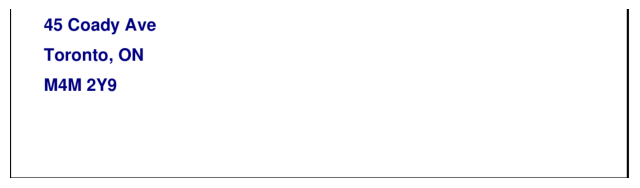

45 Coady Ave Toronto, ON M4M 2Y9


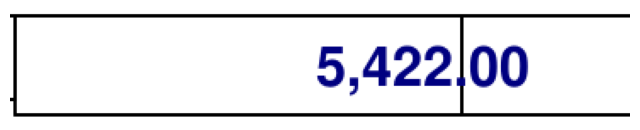

5,422/00


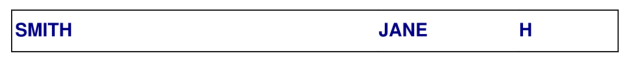

SMITH JANE H


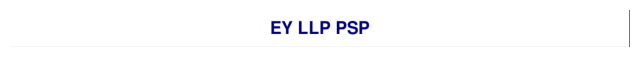

EY LLP PSP


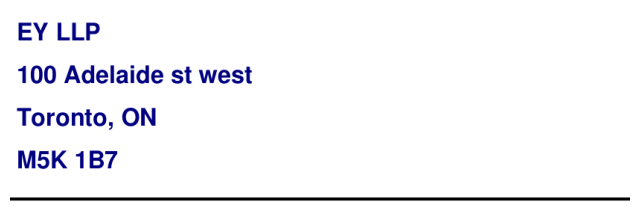

EY LLP 100 Adelaide st west Toronto, ON MSK 1B7


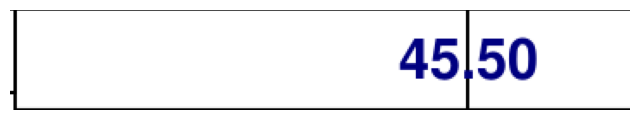

45150


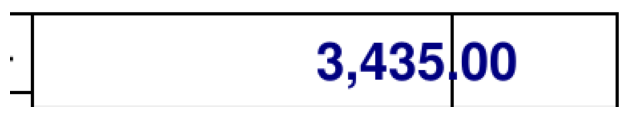

3,435/00


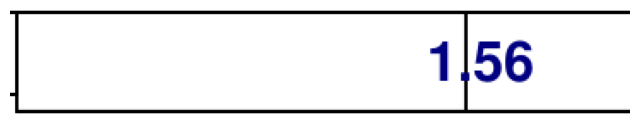

1/56


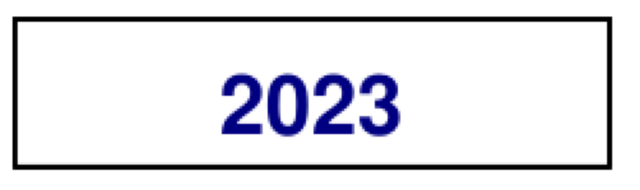

2023


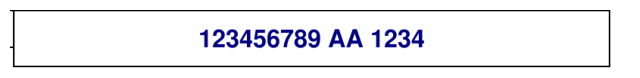

123456789 AA 1234


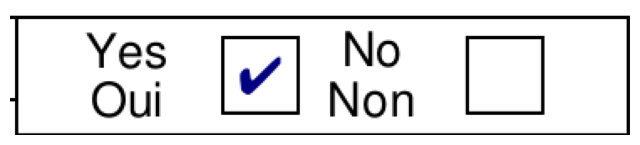

Yes No Qui Non


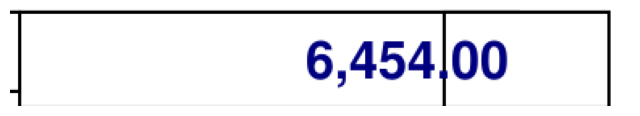

6,454400


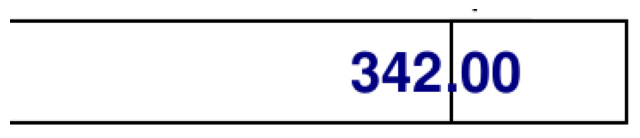

342/00


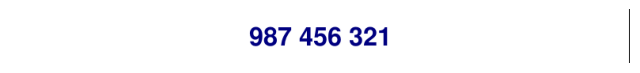

987 456 321


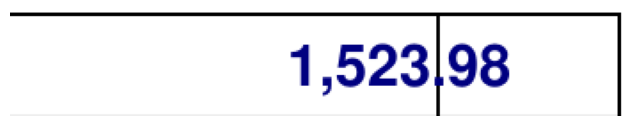

1,523/98


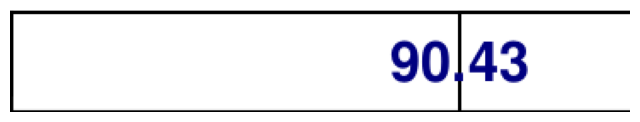

90/43


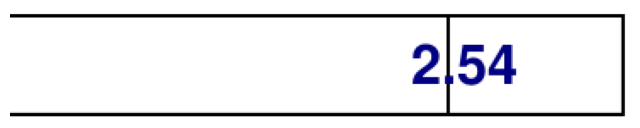

2/54


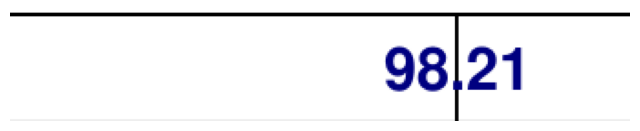

98/21


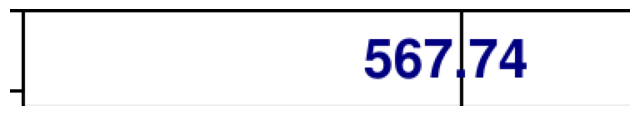

567/74


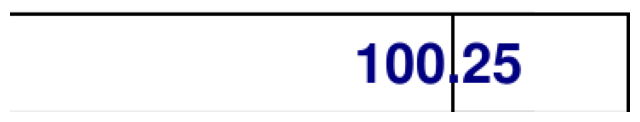

100425


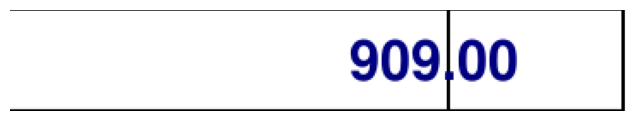

909100


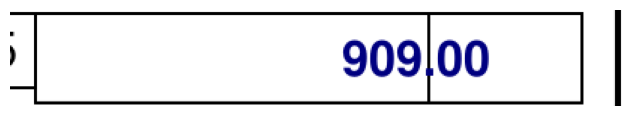

909/00


In [8]:
pdf_file_path = "t4ps-fill-23e scanned.pdf"
output_image_path = "t4ps-fill-23e scanned.png"

pdf_extractor = PDF_T4ps_ImageExtractor(pdf_file_path, output_image_path,template_json)
output_json = pdf_extractor.process_single_pdf_T4a(pdf_file_path)

In [9]:
output_json

{"Employee's address": {'Value': '45 Coady Ave Toronto, ON M4M 2Y9',
  'Coordinates': (959, 1279, 171, 1345)},
 'Employees profit sharing plan contributions': {'Value': '5,422.00',
  'Coordinates': (1365, 1430, 2025, 2390)},
 "Employee's name": {'Value': 'SMITH JANE H',
  'Coordinates': (870, 949, 221, 1316)},
 'Name of employees profit sharing plan': {'Value': 'EY LLP PSP',
  'Coordinates': (1370, 1440, 186, 1347)},
 "Employer's name": {'Value': 'EY LLP 100 Adelaide st west Toronto, ON MSK 1B7',
  'Coordinates': (180, 442, 172, 1005)},
 'Dividend tax credit eligible dividends': {'Value': '45150',
  'Coordinates': (392, 450, 2024, 2383)},
 'Actual amount of dividends other than eligible dividends': {'Value': '909.00',
  'Coordinates': (637, 701, 1542, 1955)},
 'Foreign Capital Gains or losses': {'Value': '1.56',
  'Coordinates': (1171, 1233, 1553, 1916)},
 'Year': {'Value': '2023', 'Coordinates': (88, 155, 1151, 1394)},
 "Employer's account number": {'Value': '123456789 AA 1234',
  'Co